In [2]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

## Задача Сода

Бесконечная труба заполнена воздухом ($\gamma = 1.4$), в точке $x = 0$ разделена перегородкой. При $t = 0$ слева от перегородки $(\rho, u, p)^T = (1, 0, 1)$, справа - $(\rho, u, p)^T = (0.125, 0, 0.1)$, где $\rho$ - плотность газа, $u$ - его скорость, $p$ - давление. Найти решение в момент времени $t\approx 0.504$. Считать воздух идеальным газом.

Уравнения газовой динамики и численный метод выписаны в книге [1], c.112-117. Там же приводятся графики решения, с которыми надо сверять свое решение.
1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

### Задание

Часть 1:
1. Реализовать все недостающие функции
2. Получить решение с постоянным шагом $\tau = 0.001$
3. Получить решение c $\tau_k = r\tau_{max}$, $\tau_{max}$ зависит от решения на текущем шаге. Постройте график зависимости $\tau_k$ от номера шага.
4. Прокомментировать решение, полученное в двух предыдущих пунктах
5. Укажите положение ударной волны и контактного разрыва
6. Прокомментируйте допустимость предложенного в коде варианта задания граничных условий. Стоит ли его заменить?

Часть 2: 
1. Реализуйте схему с искусственной вязкостью и проведите расчет в согласии с пунктом 3.
2. Прокомментируйте решение.

# Часть 1

### Схема Лакса-Вендроффа для решения задачи Сода

Примитивные переменные $(\rho, u, p)^T$, консервативные - $(\rho, \rho u, \rho(e + u^2/2))$.

In [3]:
nx = 101  # количество узлов по пространству
h = 2 / (nx-1) # шаг по пространству
x_mesh = np.linspace(-1, 1, nx) #сетка по пространству
gamma = 1.4 # показатель адиабаты

In [4]:
# Пересчет прититивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5*u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho*ekin])

# Пересчет консервативныx переменных в примитивные
def consToPrim(s):
    rho = s[0]
    u = s[1] / rho
    p = (s[2] - 0.5 * u ** 2 * rho) * (gamma - 1)
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    p = consToPrim(s)[2]
    return np.array([s[1], (s[1] ** 2) / s[0] + p, (s[1] / s[0]) * (s[2] + p)])

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(snm1, sn, snp1, tau, h):
    s1 = (sn + snp1) / 2 - tau * (flux(snp1) - flux(sn)) / (2 * h)
    s2 = (sn + snm1) / 2 - tau * (flux(sn) - flux(snm1)) / (2 * h) 
    return sn - tau * (flux(s1) - flux(s2)) / h

# Вычисление шага по времени
def get_tau(h, sk):
    prims = np.array([consToPrim(s) for s in sk])
    r = 0.9 # число Куранта
    tau_k = h / np.max(np.abs(prims[:, 1]) + (gamma * prims[:, 2] / prims[:, 0]) ** 0.5)
    return r * tau_k

#### Начальное условие

In [5]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### 2). Численное решение ( постоянный шаг $\tau$)

In [6]:
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = 0.001 # здесь постоянный шаг
    for n in range(1, nx - 1): # шагаем по пространству
        skp1[n] = LaxWendroff(sk[n - 1], sk[n], sk[n + 1], tau, h)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau

#### Визуализация решения

Text(0.5, 0.98, 'Solution at time t = 0.5000000000000003')

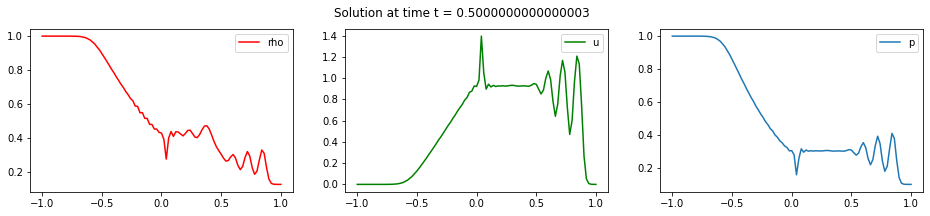

In [7]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))

#### 3). Численное решение (переменный шаг $\tau$)

In [9]:
skp1 = s0.copy() # решение на слое k+1
sk = s0.copy() # решение на слое k
t = 0
tau_list = [] 
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    tau = get_tau(h, sk) # здесь переменный шаг
    for n in range(1, nx - 1): # шагаем по пространству
        skp1[n] = LaxWendroff(sk[n - 1], sk[n], sk[n + 1], tau, h)
    tau_list.append(tau)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau

#### Визуализация решения

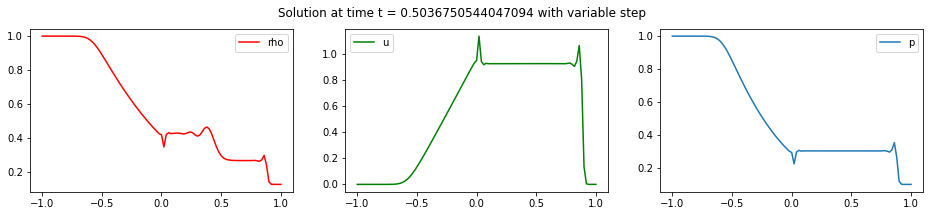

In [10]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle(f'Solution at time t = {t} with variable step')
plt.show()

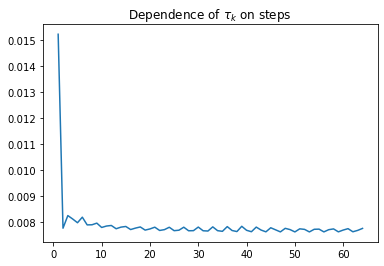

In [16]:
# построим зависимость тау от номера шага
steps = np.arange(1, len(tau_list) + 1)
plt.figure(figsize = (6, 4))
plt.title('Dependence of $\\tau_k$ on steps')
plt.plot(steps, tau_list)
plt.show()

4). Для решения с постоянным шагом наблюдаются осцилляции вблизи точек разрыва, в отличие от решения с переменным шагом - там их нет. Это происходит потому, что постоянный шаг достаточно маленький, и в точках разрыва решение сходится медленно, из-за чего на графике видны колебания. Переменный же шаг вычислен с помощью условия устойчивости схемы, он не будет слишком мелким, и с ним система будет устойчивой - колебания отсутствуют.

5). По графикам видим, что положение ударной волны находится в точке разрыва всех параметров - это примерно при $x = 0.9$. Отметим, что правее точки разрыва все параметры зануляются - т.к. волна туда еще не дошла. Контактный разрыв можно найти из графика параметра $\rho$ - он находится примерно в $x = 0.4$, правее этой точки происходит резкое уменьшение плотности среды.

6). Описанный вариант задания граничных условий допустим - он соответствует случаю, когда из трубы быстро убирают перегородку $\Rightarrow$ влево распространяется волна разряжения, а вправо контактный разрыв и ударная волна.

# Часть 2

### Схема с искусственной вязкостью

Система с вязкостью описывается следующим уравнением:
$$\frac{\partial s}{\partial t}+\frac{\partial f(s)}{\partial x}=\frac{\partial}{\partial x}\left(\mu {B}(\mathbf{s}) \frac{\partial s}{\partial x}\right),$$

где ${\mu}$ - коэффициент искусственной вязкости, ${B}({s})-$ квадратная матрица, причём подобранная так, чтобы решение системы ${s}(x, t)$ было достаточно гладким и при $\mu \rightarrow 0$ приближалось к решению исходной системы. 

Схема Лакca-Вендроффа при этом изменится следующим образом: 

$$s_{n}^{k+1}={s}_{n}^{k}-\frac{\tau_{k}}{h}\left({f}_{n+1 / 2}^{k+1 / 2}-{f}_{n-1 / 2}^{k+1 / 2}\right)+{\mu}_{a}^{k} \tau_{k}\left({s}_{n+1}^{k}-2 {s}_{n}^{k}+{s}_{n-1}^{k}\right), \; n=1, ..., N-1,$$

здесь $\nu=\mu_{a}^{k}\cdot \tau_{k}$ - постоянный малый параметр, его величина подбирается экспериментально, т.к. она зависит от конкретной задачи и шага сетки.


Ограничения на шаг по времени:
$$\tau_{k} \leqslant \tau_{\max } \sqrt{1-2 \nu}$$

In [21]:
# Новая схема Лакса-Вендроффа
def LaxWendroff(nu, snm1, sn, snp1, tau, h):
    s1 = (snp1 + sn) / 2 - tau * (flux(snp1) - flux(sn)) / (2 * h)
    s2 = (snm1 + sn) / 2 - tau * (flux(sn) - flux(snm1)) / (2 * h) 
    return sn - tau * (flux(s1) - flux(s2)) / h + nu * (snp1 - 2 * sn + snm1)

# Вычисление шага по времени
def get_tau(nu, h, sk):
    prims = np.array([consToPrim(s) for s in sk])
    r = 0.9 # число Куранта
    tau_k = h / np.max(np.abs(prims[:, 1]) + (gamma * prims[:, 2] / prims[:, 0]) ** 0.5)
    return tau_k * np.sqrt(1 - nu * 2)

#### Начальное условие

In [22]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение

In [23]:
skp1 = s0.copy()
sk = s0.copy()
t = 0
tau_list = [] 
while t < 0.5:  # шагаем по времени
    sk = skp1.copy() # заполняем данными с предыдущего шага
    nu = 0.05 # зададим значение ню
    tau = get_tau(nu, h, sk) # здесь переменный шаг
    for n in range(1, nx - 1): # шагаем по пространству
        skp1[n] = LaxWendroff(nu, sk[n - 1], sk[n], sk[n + 1], tau, h)
    tau_list.append(tau)
    # левое граничное условие
    skp1[0] = primToCons(pvl)
    # правое граничное условие
    skp1[nx - 1] = primToCons(pvr)
    t = t + tau

#### Визуализация решения

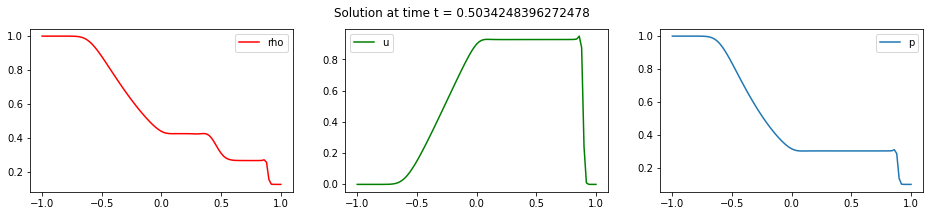

In [24]:
# переводим решение в примитивные переменные
pv_res = np.array([consToPrim(s) for s in skp1])

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res[:, 2], label='p')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('Solution at time t = ' + str(t))
plt.show()

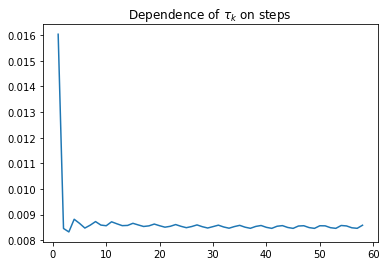

In [27]:
steps = np.arange(1, len(tau_list) + 1)
plt.figure(figsize = (6, 4))
plt.title('Dependence of $\\tau_k$ on steps')
plt.plot(steps, tau_list)
plt.show()

#### Комментарий к решению

Благодаря введению искусственной вязкости происходит затухание высокочастотных компонентов решения, а также за счет размазывания разрывов подавляются нефизические осцилляции приближенного решения. Действительно, по сравнению с графиками из части 1 здесь нет колебаний, а разрывы не так ярко выражены как раньше.